In [1]:
"""Errors might remain if Kernel is not restarted"""
"""Changes to local modules might not update if Kernel is not restarted"""

'Changes to local modules might not update if Kernel is not restarted'

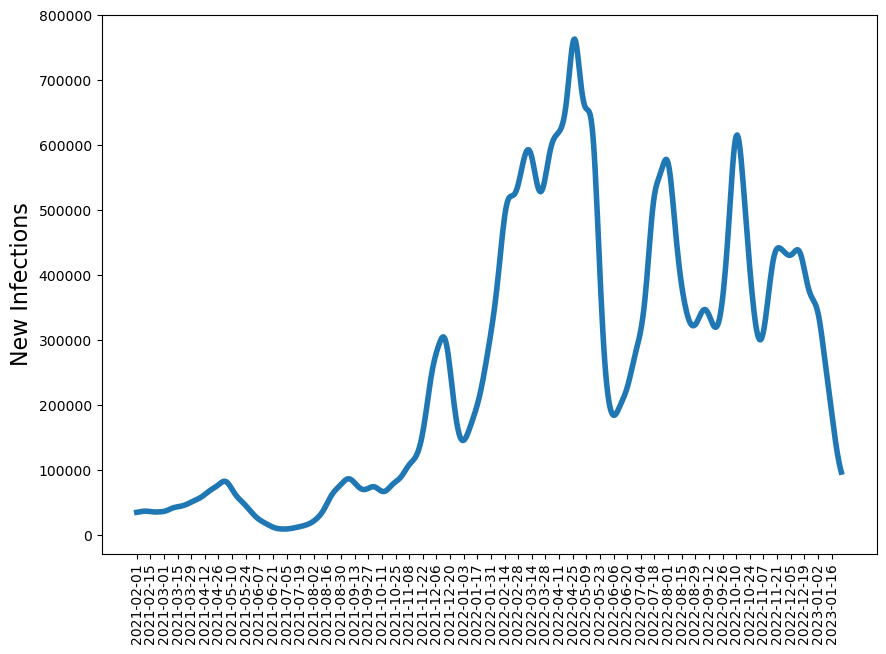

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
"""Load Infection Data"""
df = pd.read_csv('Data/caseAscertainmentTable_sinceFeb21.csv')
infection_data_corrected = df['minNTrue'].values
infection_data_reported = df['newCases'].values
"""Plot case ascertainment"""
plt.figure(figsize = (10, 7))
t = np.arange(1, len(df['date'])+1, 1) # array of timepoints at which to compute the antibody concentration
plt.plot(t, infection_data_corrected, linewidth = 4)
plt.ylabel("New Infections", fontsize = 16)
per_day = 14
t_ticks = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in df['date']]
plt.xticks(t[::per_day], t_ticks[::per_day], rotation = 90)
plt.show()

In [3]:
"""Load Escape Fraction Data and antibody classes being used"""
Escape_Fraction = pd.read_csv("Data/MEAN_MAX_mutation_escape_per_site.csv")
Ab_classes = np.unique(Escape_Fraction["group"])
"""Parameterization for Antibody PK"""
N = len(Ab_classes) # number of antibody classes
t_max = 14*np.ones(N) # time for the peak of antibody concentration for each antibody class
t_half = 48*np.ones(N) # antibody half-life for all antibody classes, respecively
params_dic = {"t_max":t_max, "t_half":t_half}
print("Considered AB classes:", Ab_classes)

Considered AB classes: ['A' 'B' 'C' 'D1' 'D2' 'E1' 'E3' 'F1' 'F2' 'F3']


In [4]:
"""Compute Antibody concentration over time"""
from Methods.PK import Antibody
is_log = False # if True, it returns the log of the antibody concentration
dataname = "Ab_%d"%N
solver = "lm" # root solver method for finding absorption rate ka (see scipy.optimize.root)
c_t, c_dframe, ka, ke, c_max_dic = Antibody(t = t, params_dic = params_dic, is_log = is_log, Ab_names = Ab_classes, save_to = "Data/"+dataname+".csv", ka_solver = solver)
#print(c_dframe, "\n k_a:", ka, "\n k_e:", ke, "\n c_max", c_max_dic)
print(" k_a:", ka, "\n\n k_e:", ke)


 k_a was found correctly: True 

 k_a: [0.20336709 0.20336709 0.20336709 0.20336709 0.20336709 0.20336709
 0.20336709 0.20336709 0.20336709 0.20336709] 

 k_e: [0.01444057 0.01444057 0.01444057 0.01444057 0.01444057 0.01444057
 0.01444057 0.01444057 0.01444057 0.01444057]


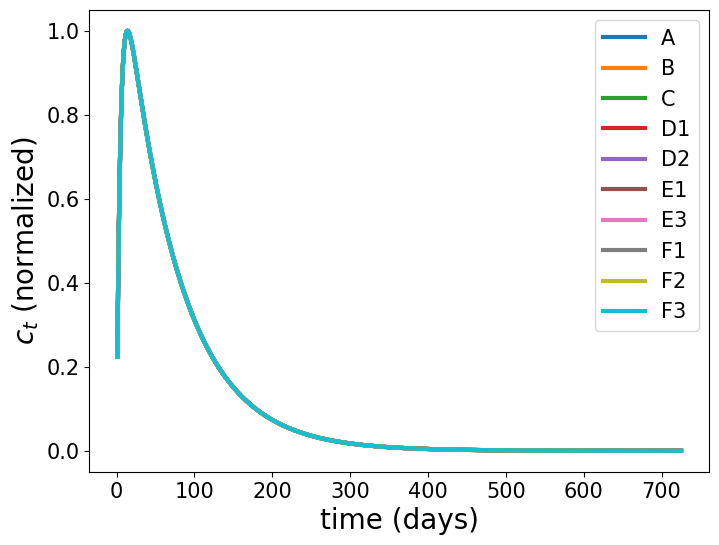

In [5]:
"""Plot Antibody concentration only if t is an array and save, default png but add extension .pdf to save as pdf"""
from Methods.figure_settings import Display
import matplotlib.pyplot as plt
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (8, 6) # figure (width, height)
labels = c_dframe.columns[1:] # Antibody class labels by orders corresponding to the rows of c_t
xval = "time (days)" # name of variable on x axis
yval = "$c_t$ (normalized)" # name of variable on y axis
Display(t, c_t, is_log, labels, 
        figsize, xysize, labsize, 
        save_to = "Figures/"+dataname+".pdf",
        xval = xval, yval = yval)
plt.legend(fontsize = 15)
plt.show()

In [6]:
"""Load Variant data"""
variant_mut_data = pd.read_csv('Data/mutationprofile_rbd_lists.tsv')
variant_x_names = variant_mut_data["lineage"]
mut_x_sites = variant_mut_data["mutated_sites_RBD"]
mut_x_sites_dic = {}
for i in range(len(variant_x_names)):
    mut_x_sites_dic[variant_x_names[i]] = mut_x_sites[i].split("/")

"""Add wild-type data """
variant_x_names = ["Wuhan-Hu-1"] + list(variant_x_names)
mut_x_sites_dic["Wuhan-Hu-1"] = [] # does not have any mutated sites 

""" Compute cross reactivity map """
from Methods.IE_Projection import cross_reactivity
Cross_react_dic, Missed, Greater_one = cross_reactivity(variant_x_names, Escape_Fraction, Ab_classes, 
                                                        mut_x_sites_dic, EF_func = "MAX", GM = False)

Denote $\mathcal{M}_x$ the set of mutated sites of variant $x$ and $\mathcal{M}_y$ the set of mutated sites of variant $y$

Cross reactivity map contains the fold resistance $FR_{x,y}(AB)$: the fold resistance of a variant $y$ given that $AB$ is ellicited by another variant $x$. It is given by 

$$
FR_{x,y}(AB) = \prod_{s \in \mathcal{M}_x \Delta \mathcal{M}_y }FR_s(AB),
$$
where
$$
FR_s(AB) = \dfrac{100}{\dfrac{1}{f(EF_{s}(AB))} - 1},
$$

where $EF_{s}(AB)$ is escape fraction at site $s$ exposed to $AB$ given at antibody concentration $[AB] = 100\,\times$ IC50$_{x,x}$, and $f(\cdot) = mean(max (\cdot)) $ or $f(\cdot) = max(mean (\cdot)) $ (parameter EF_func)

We considere the symmetric difference $\mathcal{M}_x \Delta \mathcal{M}_y $ of the mutated sites because if an antibody can neutralize a mutation site $s$, it means that it is specifically adapted to this mutation site and is not necessarily adapted to the non-mutated version of the site. 


In [7]:
for s in Missed:
    print(s)
print("\n")
for s in Greater_one:
    print(s)
print(variant_x_names)



['Wuhan-Hu-1', 'BA.1.1.1', 'BA.1.1', 'BA.1.17.2', 'BA.1.18', 'BA.1', 'BA.2.12.1', 'BA.2.18', 'BA.2.3', 'BA.2.36', 'BA.2.9', 'BA.2', 'BA.4.1', 'BA.4.6', 'BA.4', 'BA.5.1.10', 'BA.5.1.22', 'BA.5.1.23', 'BA.5.1.3', 'BA.5.1.30', 'BA.5.1.5', 'BA.5.1', 'BA.5.2.1', 'BA.5.2.20', 'BA.5.2.26', 'BA.5.2.34', 'BA.5.2.6', 'BA.5.2', 'BA.5.3.1', 'BA.5.3.2', 'BA.5.3.4', 'BA.5.3', 'BA.5.6', 'BA.5.9', 'BA.5', 'BE.1.1.2', 'BE.1.1', 'BE.1', 'BF.1', 'BF.11', 'BF.14', 'BF.5', 'BF.7.4', 'BF.7.5', 'BF.7.6', 'BF.7', 'BN.1.2', 'BN.1.3.1', 'BN.1.3', 'BQ.1.1.13', 'BQ.1.1.18', 'BQ.1.1.4', 'BQ.1.1.7', 'BQ.1.1', 'BQ.1.18', 'BQ.1.2', 'BQ.1', 'CH.1.1', 'CL.1', 'XBB.1']


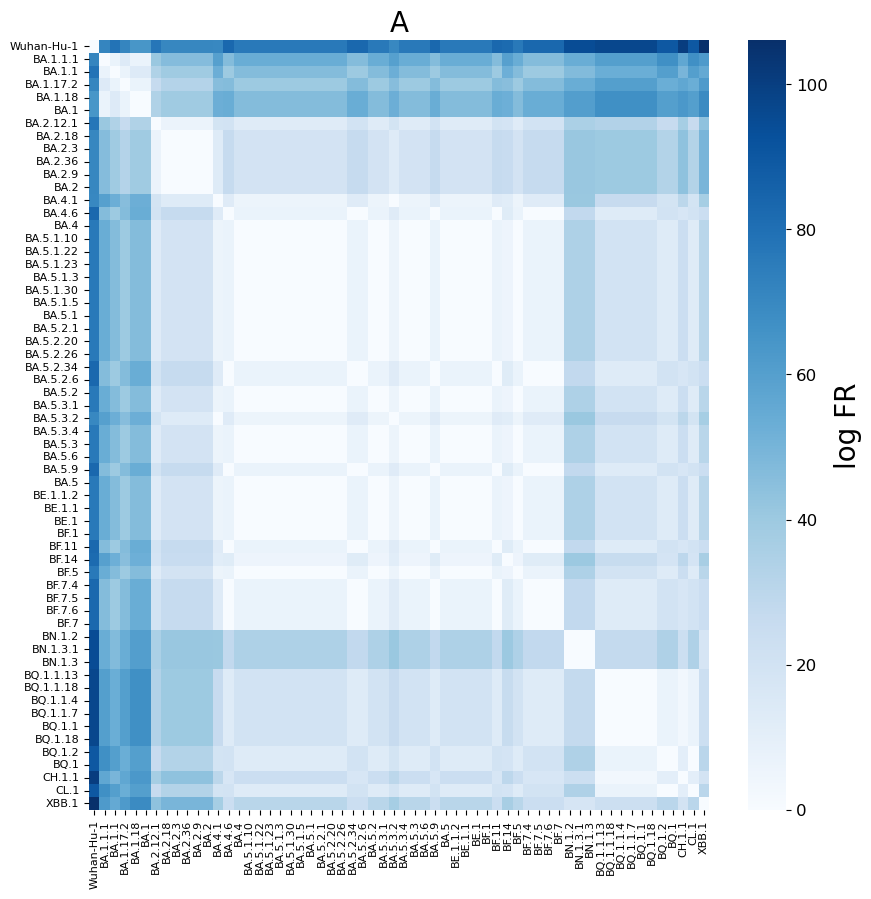

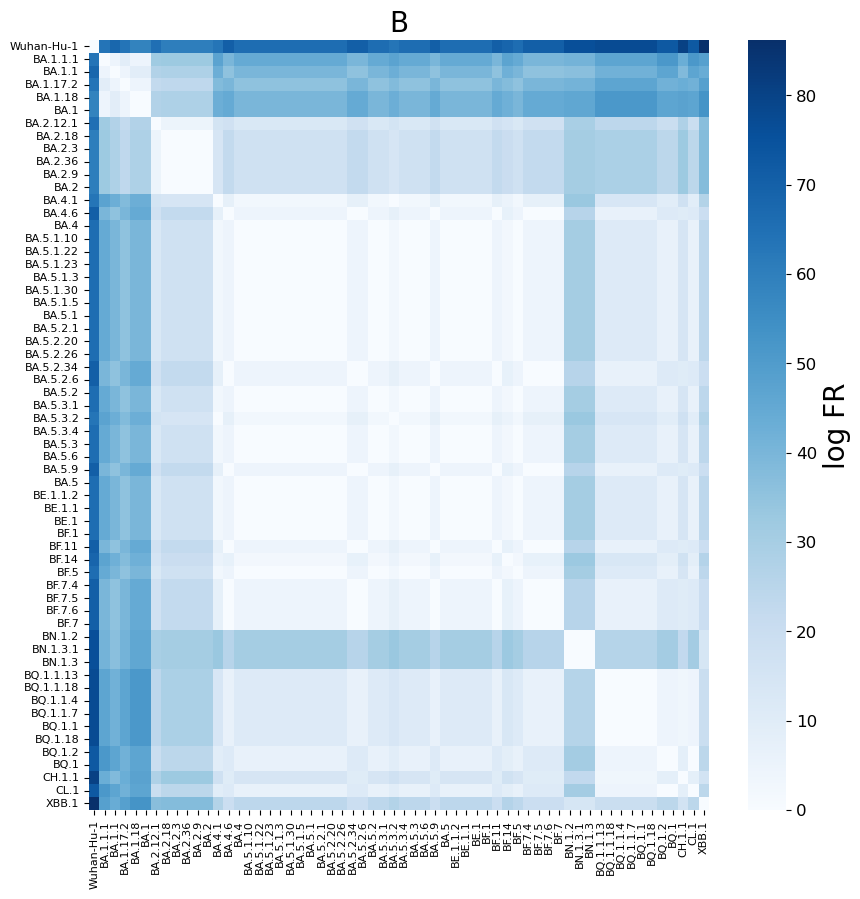

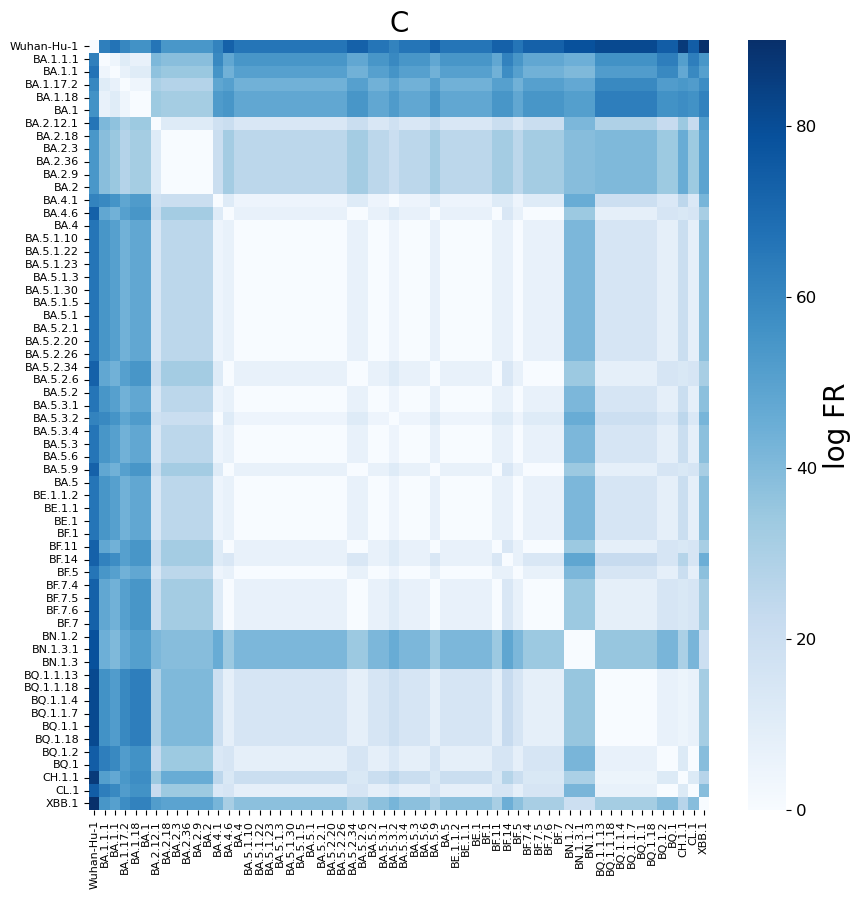

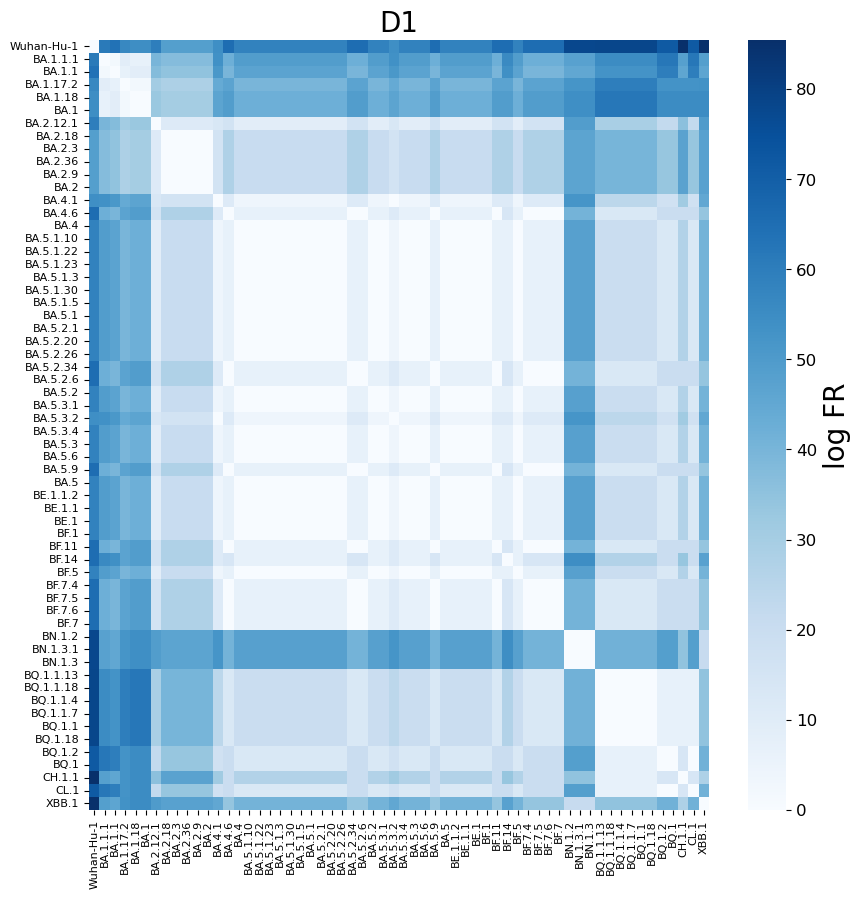

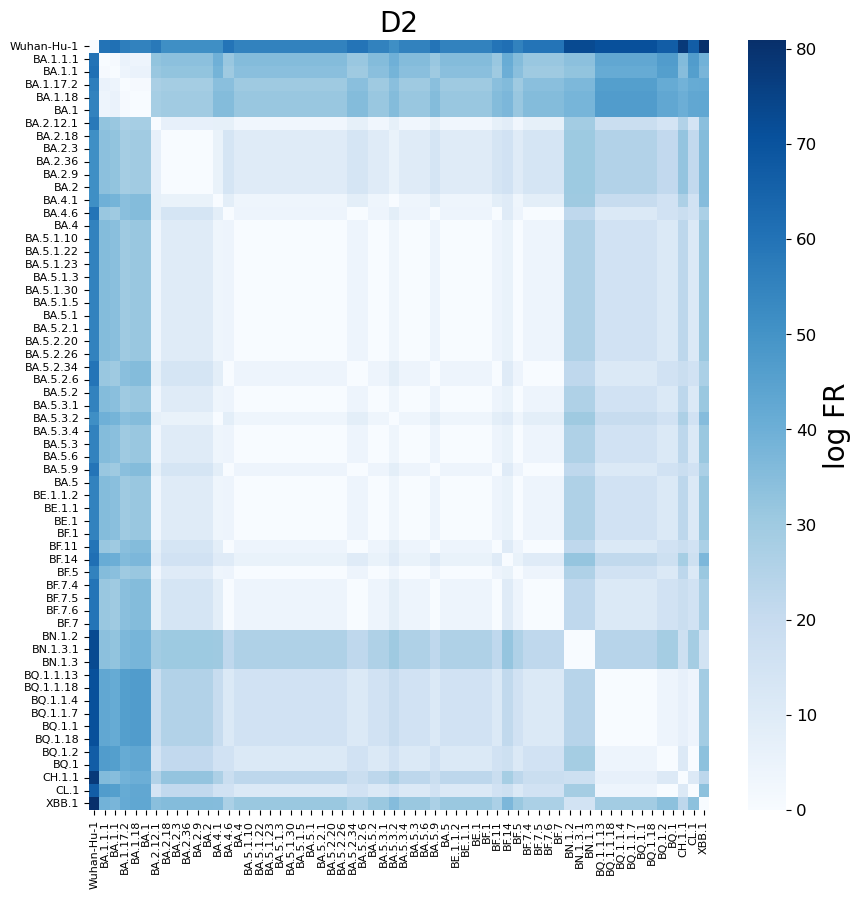

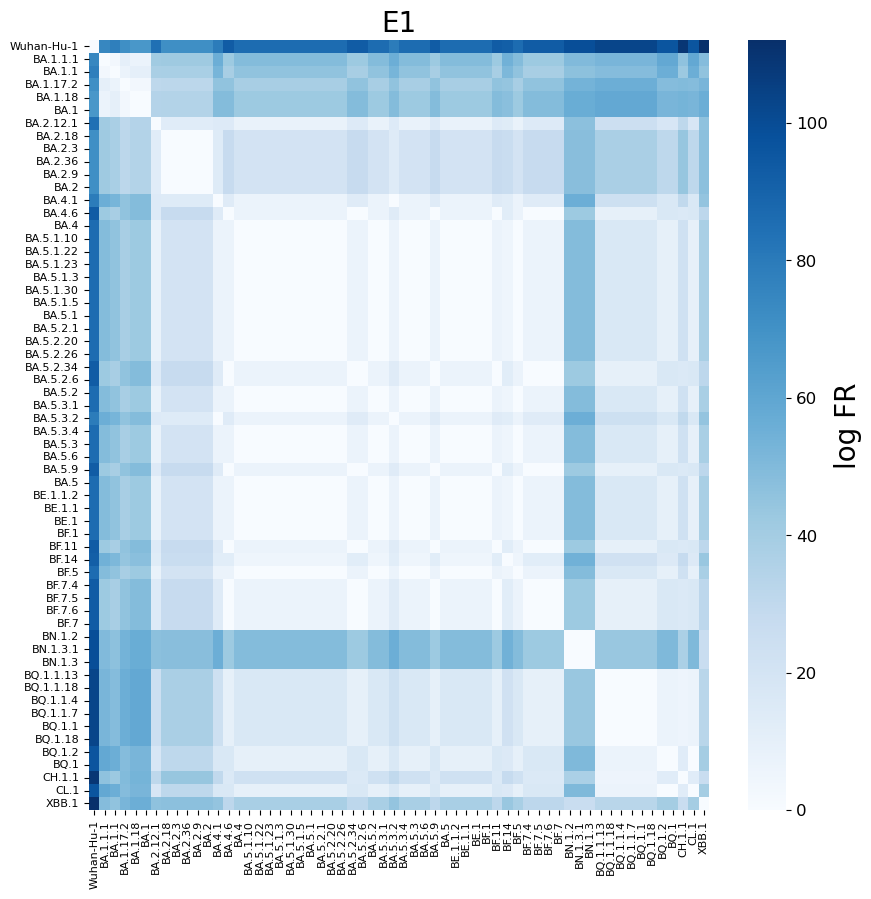

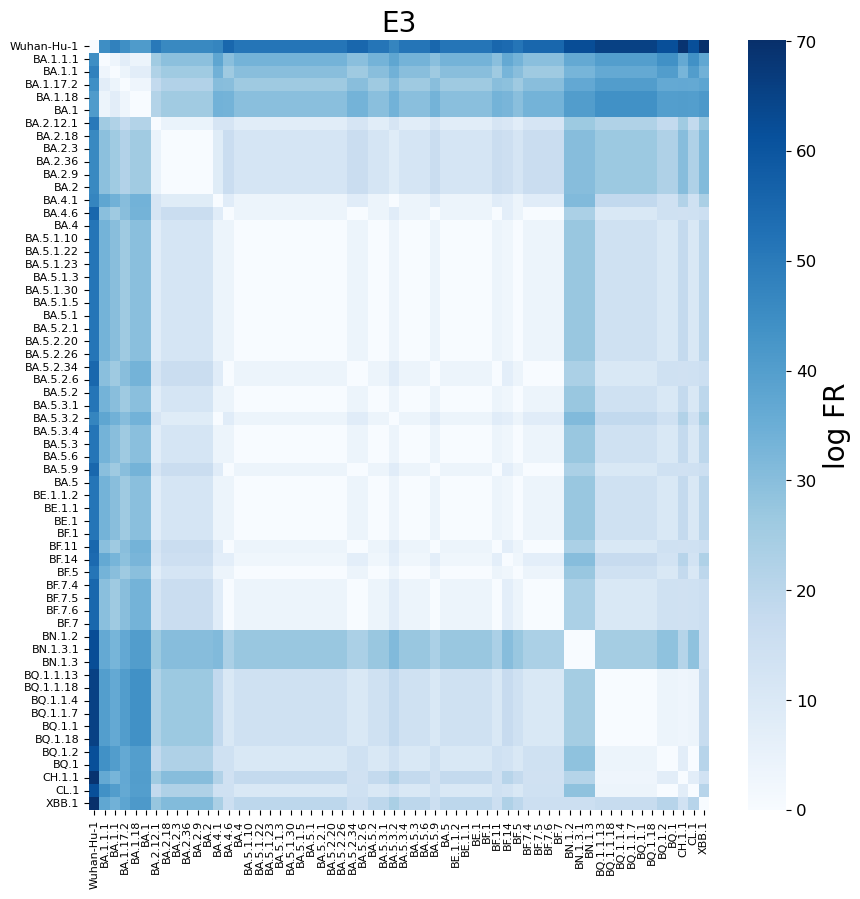

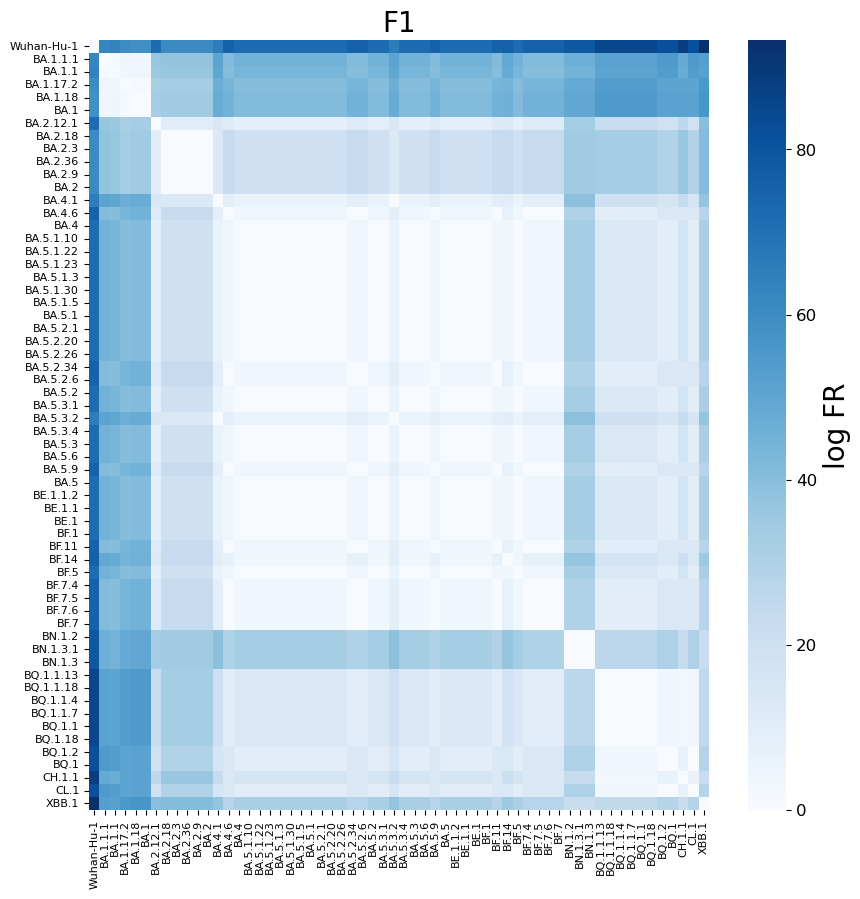

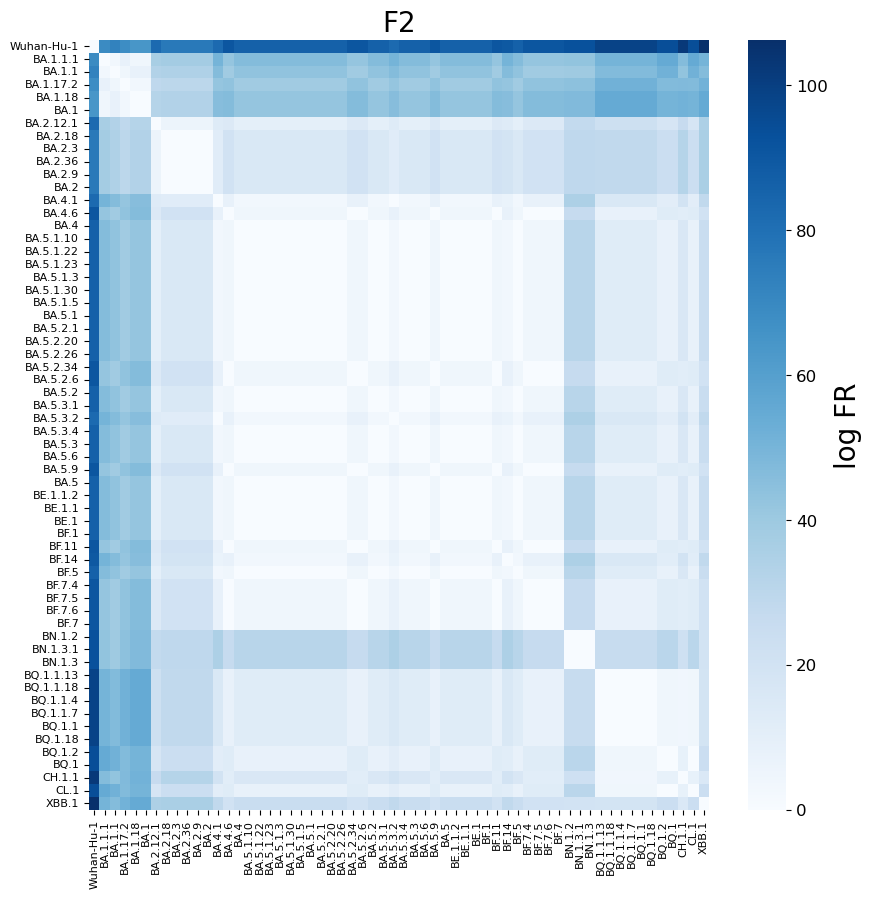

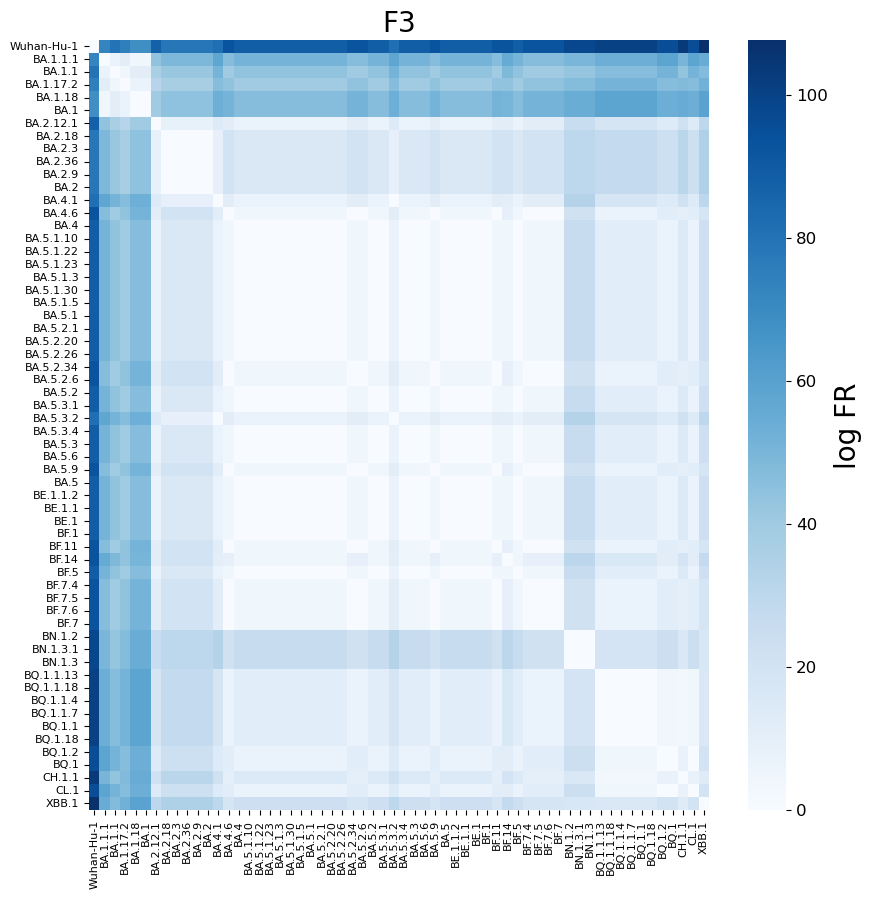

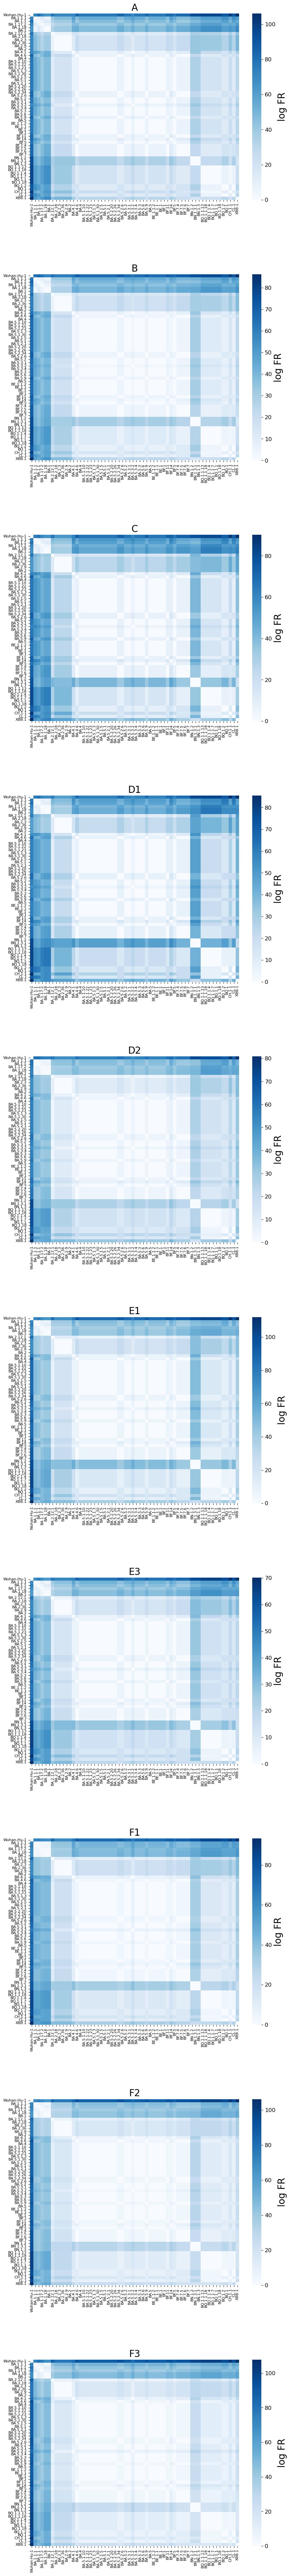

In [8]:
"""Plot Cross Reactivity Map"""
from Methods.figure_settings import Heatmap
import seaborn as sns

num_col = 1
Cross_react_dic_log = {}
for ab in Ab_classes:
    Cross_react_dic_log[ab] = np.log(Cross_react_dic[ab])

if len(variant_x_names)%num_col == 0:
    num_row = int(len(variant_x_names)//num_col)
else:
    num_row = int(len(variant_x_names)//num_col) + 1
    
fig = Heatmap(data_dic = Cross_react_dic_log, 
        row_labels = variant_x_names,
        col_labels = variant_x_names,
        annotsize = None, # if None then there will be no annotations but instead a colobar
        cbar_kws= {'label': 'log FR'}, # colorbar keyword arguments
        cbar_labsize = 20, # size of colorbar label
        colormap = sns.color_palette("Blues", as_cmap=True),
        save_to = "Figures/cross_reactivity_new",
        sub_fig_size = 10, # subfig size
        num_row_col = (num_row,num_col), # number of row and columns of figure
        ticksize = (8, 8) ) # fontsize of row, col labels

In [9]:
"""Checking results"""
ab = "A"
test = Cross_react_dic_log[ab]
print("Variants considered",list(variant_x_names))
id1 = 11
id2 = 20
v1 = list(variant_x_names)[id1]
v2 = list(variant_x_names)[id2]
mut_v1 = set(mut_x_sites_dic[v1]) 
mut_v2 = set(mut_x_sites_dic[v2])
EF_AB = (Escape_Fraction["max_escape_fraction_per_site"].values).copy()
print("")
print("Tested 1", v1, mut_v1)
print("")
print("Tested 2", v2, mut_v2)
print("")
M = list(mut_v1.symmetric_difference(mut_v2))
print("Symmetric difference", M)

"MAX of MEAN Escape fraction"
FR_s = np.ones(len(M))
for i in range(len(M)):
    s = M[i]
    where_s_AB = ((Escape_Fraction["site"].values).astype(str) == str(s)) & ((Escape_Fraction["group"].values).astype(str) == str(ab))
    FR_s[i] = 100*EF_AB[where_s_AB]/(1 - EF_AB[where_s_AB])
    print(s, FR_s[i])

print("Thus log(FR_(v1, v2) (%s)) = "%ab, np.log(np.prod(FR_s)), "Found by function is", test[id1, id2])

Variants considered ['Wuhan-Hu-1', 'BA.1.1.1', 'BA.1.1', 'BA.1.17.2', 'BA.1.18', 'BA.1', 'BA.2.12.1', 'BA.2.18', 'BA.2.3', 'BA.2.36', 'BA.2.9', 'BA.2', 'BA.4.1', 'BA.4.6', 'BA.4', 'BA.5.1.10', 'BA.5.1.22', 'BA.5.1.23', 'BA.5.1.3', 'BA.5.1.30', 'BA.5.1.5', 'BA.5.1', 'BA.5.2.1', 'BA.5.2.20', 'BA.5.2.26', 'BA.5.2.34', 'BA.5.2.6', 'BA.5.2', 'BA.5.3.1', 'BA.5.3.2', 'BA.5.3.4', 'BA.5.3', 'BA.5.6', 'BA.5.9', 'BA.5', 'BE.1.1.2', 'BE.1.1', 'BE.1', 'BF.1', 'BF.11', 'BF.14', 'BF.5', 'BF.7.4', 'BF.7.5', 'BF.7.6', 'BF.7', 'BN.1.2', 'BN.1.3.1', 'BN.1.3', 'BQ.1.1.13', 'BQ.1.1.18', 'BQ.1.1.4', 'BQ.1.1.7', 'BQ.1.1', 'BQ.1.18', 'BQ.1.2', 'BQ.1', 'CH.1.1', 'CL.1', 'XBB.1']

Tested 1 BA.2 {'375', '408', '501', '339', '417', '505', '493', '376', '498', '405', '477', '478', '371', '484', '373'}

Tested 2 BA.5.1.5 {'375', '408', '501', '339', '417', '505', '452', '376', '440', '486', '405', '477', '498', '478', '371', '484', '373'}

Symmetric difference ['440', '452', '486', '493']
440 439.0835579514825
452 

IC50xx: 3.3095892106892486


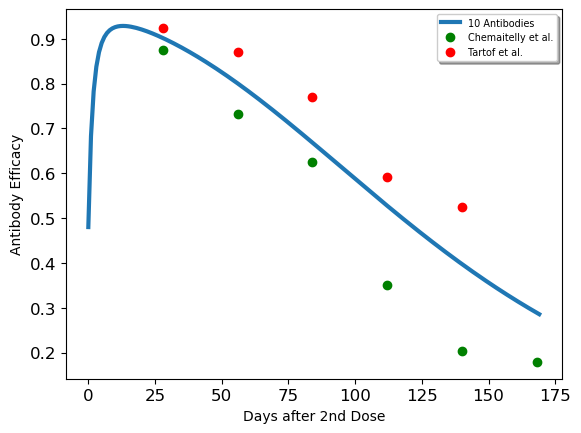

In [10]:
"""Set up the vaccine efficacy data which is used for fitting"""
from Methods.VE import sqrt_diff, vaccine_efficacy_four_antibodies, vaccine_efficacy_n_antibodies
import matplotlib.pyplot as plt
days = np.array([1,2,3,4,5,6])*28
ve_data_1 = np.array([87.6, 73.3, 62.4, 35.1, 20.4, 17.9])/100
ve_data_2 = np.array([0.92423, 0.87141, 0.76936, 0.59191, 0.52525])
ve_data = [ve_data_1, ve_data_2]

from scipy.optimize import root
guess = 0.2
IC50_data = root(sqrt_diff, guess, args = (days, ve_data, len(Ab_classes), c_dframe), method = "lm").x
print("IC50xx:", IC50_data[0])
ve_estimate = np.zeros(170)
for i in range(170):
    antibody_level = c_dframe.loc[i][1:]
    ve_estimate[i] = vaccine_efficacy_n_antibodies(antibody_level, IC50_data)

plt.plot(range(170), ve_estimate, label = "%s Antibodies"%len(Ab_classes), linewidth = 3)
plt.plot(days, ve_data_1,'go', label = "Chemaitelly et al.")
plt.plot(days[0:5], ve_data_2, 'ro', label = "Tartof et al.")
plt.xlabel("Days after 2nd Dose")
plt.ylabel("Antibody Efficacy")
plt.legend(loc='upper right', shadow=True, fontsize='x-small')
plt.show()

In [11]:
"""Variant proportion over time"""
variant_prop_data = pd.read_csv('Data/sublinFreq_perKW_Stichprobe_RKI-MARtoDEC-2022-2023-01-24.tsv', sep = "\t")
week_num = variant_prop_data["week_num"].values
lineage = (variant_prop_data["lineage"].values).astype(str)
weekly_freq = variant_prop_data["freq_per_KW"].values
weekly_counts = variant_prop_data["counts_per_KW"].values
unique_lineage = np.unique(lineage)


days = list(df['date'])
last_day = "2022-12-31" # last day of variant prop data
where_last_day = days.index(last_day)

# reconstruct number of days
unique_weeks = np.unique(week_num)
weeks_locs = np.linspace(0, len(unique_weeks) - 1, len(unique_weeks))
day_new = np.linspace(0, len(unique_weeks) - 1, (len(unique_weeks))*7) ### one week = 7 days always

# initializing variant proportion for all lineages
prop_lineage = np.zeros(len(unique_lineage)+1)
proportion_lineage = np.tile(prop_lineage, (len(t), 1))

"""Variant-propotions on the first day 2022 --- Assuming only wild-type is present"""
mar2022 = days[where_last_day + 1 - len(day_new)]  # first day of variant prop data
where_first_day = days.index(mar2022) 
proportion_lineage[:where_first_day, 0] = 1 

from scipy.interpolate import interp1d
import pdb
for x in range(len(unique_lineage)):
    variant = unique_lineage[x]
    ### propotion corresponding to variant
    #weekly_count_x = weekly_counts[lineage == variant]
    weekly_freq_x = weekly_freq[lineage == variant]
    ### weeks for corresponding to variant 
    week_x = week_num[lineage == variant]

    prop_x_data = np.zeros(len(unique_weeks))
    for w in week_x:
        id_w = list(unique_weeks).index(w)
        #prop_x_sparce[id_w] = weekly_count_x[week_x == w]/np.sum(weekly_counts[week_num == w])
        prop_x_data[id_w] = weekly_freq_x[week_x == w]/100

    ### interpolate weekly poportion into daily proportion
    f = interp1d(weeks_locs, prop_x_data)
    proportion_lineage[where_first_day:where_last_day+1, x+1] = f(day_new)

    
print("Check that the total variant proportion - following lineages --- sums up to one everyday")
Summed_Prop = np.sum(proportion_lineage[:where_last_day+1], axis = 1)
print(np.all(np.isclose(Summed_Prop , np.ones(len(t[:where_last_day+1])))))

print(len(lineage), len(np.unique(lineage)))
"""Save unique lineage"""
df_lin = pd.DataFrame({"lineage":unique_lineage})
df_lin.to_csv("Data/test_lineages_Stichprobe_RKI-MARtoDEC-2022-2023-01-24.csv")
print(df_lin)

Check that the total variant proportion - following lineages --- sums up to one everyday
True
6888 624
      lineage
0      AY.121
1    AY.121.1
2      AY.122
3      AY.127
4    AY.4.2.3
..        ...
619        XM
620        XN
621        XV
622        XW
623        XZ

[624 rows x 1 columns]


In [12]:
"""Consider variants that sums up to above 90%"""
prop_variant_considered = np.zeros((len(t), len(unique_lineage)))
proportion_lineage_considered = proportion_lineage[:, 1:] # remove wild_t
cut_off = 0.95
for k in range(where_first_day, where_last_day+1):
    sub_sort = np.argsort(proportion_lineage_considered[k, :])[::-1] # decreasing order
    cum_sort = np.cumsum(proportion_lineage_considered[k, sub_sort])
    where_cut_off = np.where(np.isclose(1*(cum_sort>=cut_off), np.ones(len(cum_sort))))[0][0]
    prop_variant_considered[k, sub_sort[:where_cut_off+1]] = proportion_lineage_considered[k, sub_sort[:where_cut_off+1]]

Number of UNIQUE lineages in Sofia's variant proportion data: 624 
Number of lineages involved in directly summing up to >= 0.95 at every time point: 624


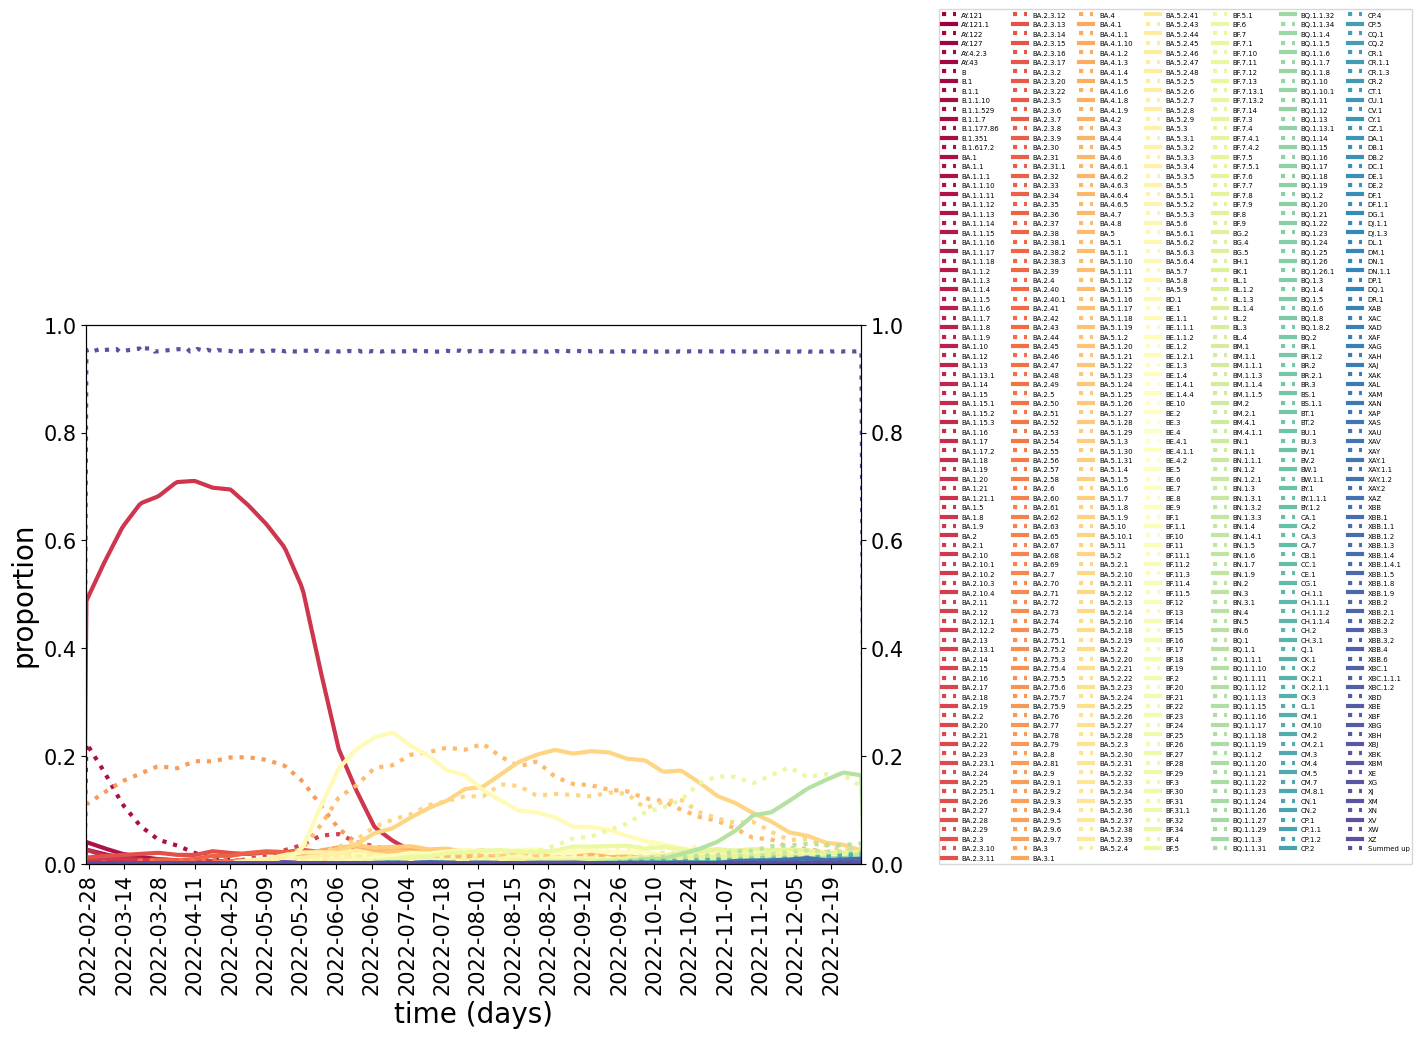

In [13]:
considered_indexes = np.any(proportion_lineage_considered != 0, axis = 0)
variant_x_list = list(unique_lineage[considered_indexes])
print("Number of UNIQUE lineages in Sofia's variant proportion data:", len(unique_lineage), "\nNumber of lineages involved in directly summing up to >= %.2f at every time point:"%cut_off, len(variant_x_list))
variant_proportion = np.zeros((len(t), 1+len(variant_x_list)))
for variant in variant_x_list:
    x = list(variant_x_list).index(variant)
    if variant == "Wuhan-Hu-1":
        variant_proportion[:, x] = proportion_lineage[:, 0]
    else:
        x_lin = list(unique_lineage).index(variant)
        variant_proportion[:, x] = prop_variant_considered[:, x_lin]
        
"""Plot variant proportions over time without the wild type"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
xval = "time (days)" # name of variable on x axis
yval = "proportion" # name of variable on y axis
labels = variant_x_list

"""Select variants to plot"""
variant_to_plot = variant_x_list #["Wuhan-Hu-1", "BA.5.1.5", "BF.5"]
index_var = np.array([variant_x_list.index(var_y) for var_y in variant_to_plot])

Var_prop_data = np.row_stack((variant_proportion.T[index_var, :], np.sum(variant_proportion.T, axis = 0)))
labs_data = list(np.array(labels)[index_var]) + ["Summed up"]

fig, ax = Display(t, Var_prop_data, is_log, labs_data, 
        figsize, xysize, labsize, 
        save_to = "Figures/Variant_Proportions.pdf",
        xval = xval, yval = yval, linewidth = 3,
        palette = "Spectral",
        linestyle = [":", "-"]*int((len(labels)//2)+1))
                  
plt.legend(fontsize = 10, loc = (1.1, 0.))
per_day = 14
plt.xticks(t[::per_day], t_ticks[::per_day], rotation = 90)
plt.legend(fontsize = 5, loc = (1.1, 0.), ncol = 7)
plt.xlim((t[where_first_day], t[where_last_day]))
#ax.hlines(1, xmin = 0, xmax = t[where_last_day], linestyle = "--",linewidth = 2, color = "black", label = mar2022)
ax1 = ax.twinx()
ax.set_ylim((0, 1))
ax1.set_ylim((0,1))
#plt.xlim((t[0], t[where_last_day]))
plt.show()           

In [14]:
"""Expected Immunity Efficacy as a function of COV19 variant proportions """
from Methods.IE_Projection import Immunity_dynamics
from Methods.VE import efficacy_n_antibodies

PK_dframe = c_dframe
IC50xx = {Ab_classes[i]:IC50_data for i in range(len(Ab_classes))} # assuming the same IC50 for all AB


IM_list = []
labels = []
variant_x_list = variant_x_names

for y in range(len(variant_x_list)):
    """ Immunity Dynamics """
    variant = variant_x_list[y]
    variant_y_list = [variant] # variants observed during to whole time window
    var_y_lab = "%s       "*len(variant_y_list)
    var_y_all = var_y_lab%tuple(variant_y_list)
    labels.append("Test. var y = %s"%var_y_all)
    """
    Expected_Immunized_xy = Immunity_dynamics(t, PK_dframe, infection_data_corrected, 
                                        present_variant_list = variant_x_list, 
                                        tested_variant_list = variant_y_list, 
                                        variant_name   = variant_x_list, # (variant_proprotion.shape[1])
                                        variant_proportion = variant_proportion, 
                                        Ab_classes = Ab_classes, 
                                        IC50xx = IC50xx, 
                                        Cross_react_dic = Cross_react_dic,
                                        parallel = True)
   
    IM_list.append(Expected_Immunized_xy)
    print("%d out of %d"%(y, len(variant_x_list)), "Variant %s Tested "%variant)
     """
#Expected_Immunized = np.row_stack(tuple(IM_list))
""" Save results """
"""
res_dic = {}
for y in range(len(variant_x_list)):
    res_dic[variant_x_list[y]] = IM_list[y]
res_df = pd.DataFrame(res_dic, index = t_ticks)
res_df.to_csv("Data/Expected_Immunized_test.csv")
"""

'\nres_dic = {}\nfor y in range(len(variant_x_list)):\n    res_dic[variant_x_list[y]] = IM_list[y]\nres_df = pd.DataFrame(res_dic, index = t_ticks)\nres_df.to_csv("Data/Expected_Immunized_test.csv")\n'

Denote $\mathcal{X}$ the set of variants present during the time-range and $\mathcal{Y}$ the set of variants we want to evaluate.


The Expected Immunity Efficacy to the variants in $\mathcal{Y}$ (number of Immunized Individuals) as a function of COV19 variant proportions is

$$
\mathbb{E}_y[\text{Immunized}(k)] =  \sum_{x\in \mathcal{X}} \sum\limits_{l<k} \mathbb{E}\left[\text{Infected}(\text{variant } x,\, l)\right]\cdot \text{Prob}_\text{Neut}(k - l,\, \text{FR}_{ x,\, y}),
$$
where
\begin{equation}
\begin{split}
\mathbb{E}\left[\text{Infected}(\text{variant } x,\, l)\right]
& = 
\text{Proportion}(\text{variant } x,\, l) \cdot \mathbb{E}\left[\text{Infected}(l)\right]\\
& = \text{Proportion}(\text{variant } x,\, l) \cdot \text{ Cases}(l).
\end{split}
\end{equation}

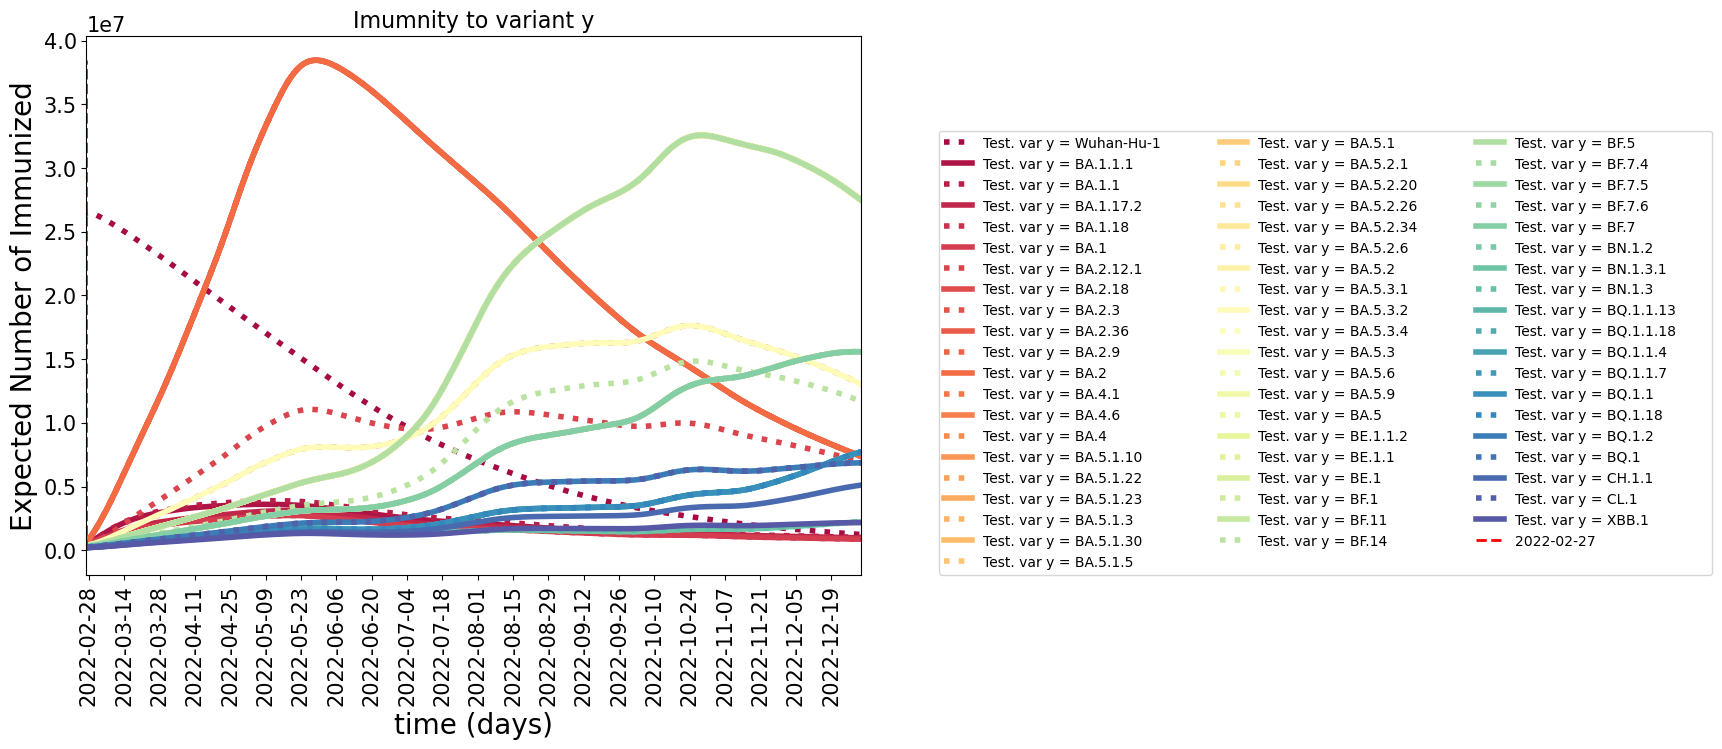

In [15]:
""" Load and Plot pre-runned results """
IM_Data = pd.read_csv("Data/Expected_Immunized.csv")
IM_Data.drop(columns = "Unnamed: 0", inplace = True)
Expected_Immunized_load = np.array(IM_Data.loc[:][:].values).T

"""Plot Expected Immunity Efficacy, default png but add extension .pdf to save as pdf"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
xval = "time (days)" # name of variable on x axis
yval = "Expected Number of Immunized" # name of variable on y axis

"""Select variants to plot """
variant_to_plot = variant_x_list# ["Wuhan-Hu-1", "BA.5.1.5", "BF.5"]  
index_var = np.array([variant_x_list.index(var_y) for var_y in variant_to_plot])

fig, ax = Display(t, Expected_Immunized_load[index_var, :], is_log, np.array(labels)[index_var], 
        figsize, xysize, labsize, 
        save_to = "Figures/IE_Projection.pdf",
        xval = xval, yval = yval, linewidth = 4, 
                 palette = "Spectral",
                  linestyle = [":", "-"]*int((len(labels)//2)+1))
plt.title("Imumnity to variant y", fontsize  = 16)
per_day = 14
plt.xticks(t[::per_day], t_ticks[::per_day], rotation = 90)
ax.vlines(t[list(df['date']).index(mar2022)], ymin = 0, ymax = np.max(Expected_Immunized_load), linestyle = "--",linewidth = 2, color = "red", label = mar2022)
plt.legend(fontsize = 10, loc = (1.1, 0.), ncol = 3)
plt.xlim((t[where_first_day], t[where_last_day]))
#plt.xlim((t[0], t[where_last_day]))
plt.show()

In [16]:
""" Compute fold resistance to neutralization """
Fold_res = []
y2 = variant_x_list.index("BA.5")
labels_r = []
"""Select variants to plot """
variant_to_plot = variant_x_list# ["Wuhan-Hu-1", "BA.5.1.5", "BF.5"]  
index_var = np.array([variant_x_list.index(var_y) for var_y in variant_to_plot])

for y1 in range(len(variant_to_plot)):
          
        Rate = np.divide(Expected_Immunized_load[y2, :], Expected_Immunized_load[index_var[y1], :], out = 999*np.ones(len(t)), where = Expected_Immunized_load[index_var[y1], :]!=0)

        Fold_res.append(Rate)
        labels_r.append("$y_1$ = %s"%variant_to_plot[y1])
Fold_res = np.row_stack(tuple(Fold_res))

The fold resistance to neutralization measures how dangerous is variant $y_1$ as compared to another variant $y_2$ and can be computed by

$$
R(y_1\, \text{vs.}\, y_2, k) = \dfrac{\mathbb{E}_{y_2}[\text{Immunized}(k)]}{\mathbb{E}_{y_1}[\text{Immunized}(k)]}
$$


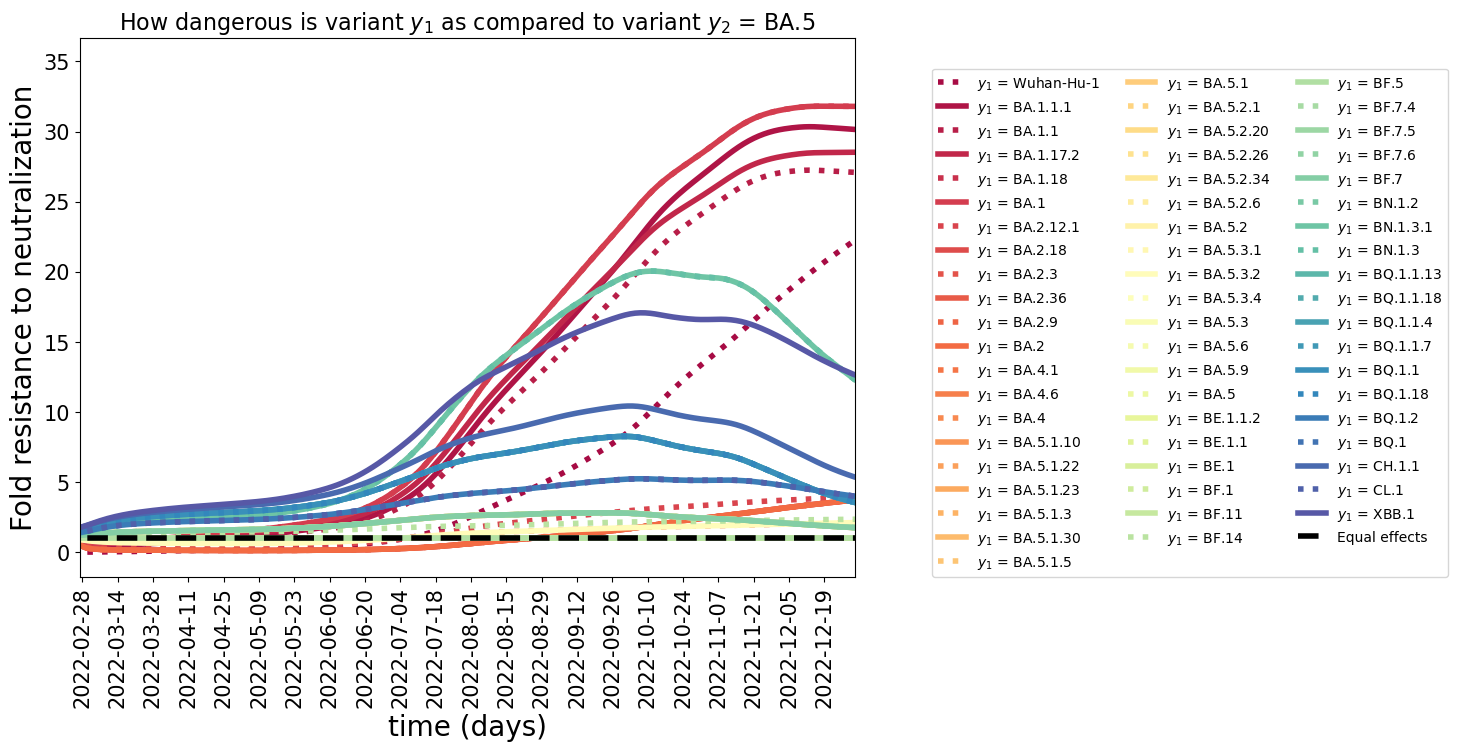

In [18]:
"""Plot fold resistance to neutralization, default png but add extension .pdf to save as pdf"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
xval = "time (days)" # name of variable on x axis
yval = "Fold resistance to neutralization" # name of variable on y axis

fig, ax = Display(t, Fold_res, is_log, np.array(labels_r), 
        figsize, xysize, labsize, 
        save_to = "Figures/Neut_reduction_rate.pdf",
        xval = xval, yval = yval, linewidth = 4, 
                 palette = "Spectral",
                  linestyle = [":", "-"]*int((len(labels_r)//2)+1))
plt.title("How dangerous is variant $y_1$ as compared to variant $y_2$ = %s"%variant_x_list[y2], fontsize  = 16)
per_day = 14
plt.xticks(t[::per_day], t_ticks[::per_day], rotation = 90)
#ax.vlines(t[list(df['date']).index(mar2022)], ymin = 0, ymax = np.max(Neut_rate), linestyle = "--",linewidth = 2, color = "red", label = mar2022)
ax.hlines(1, xmin = 0, xmax = np.max(t), linestyle = "--",linewidth = 4, color = "black", label = "Equal effects")
plt.legend(fontsize = 10, loc = (1.1, 0.), ncol = 3)
plt.xlim((t[where_first_day], t[where_last_day]))
#plt.ylim((0, np.max(Neut_rate)))
#plt.xlim((t[0], t[where_last_day]))
plt.show()

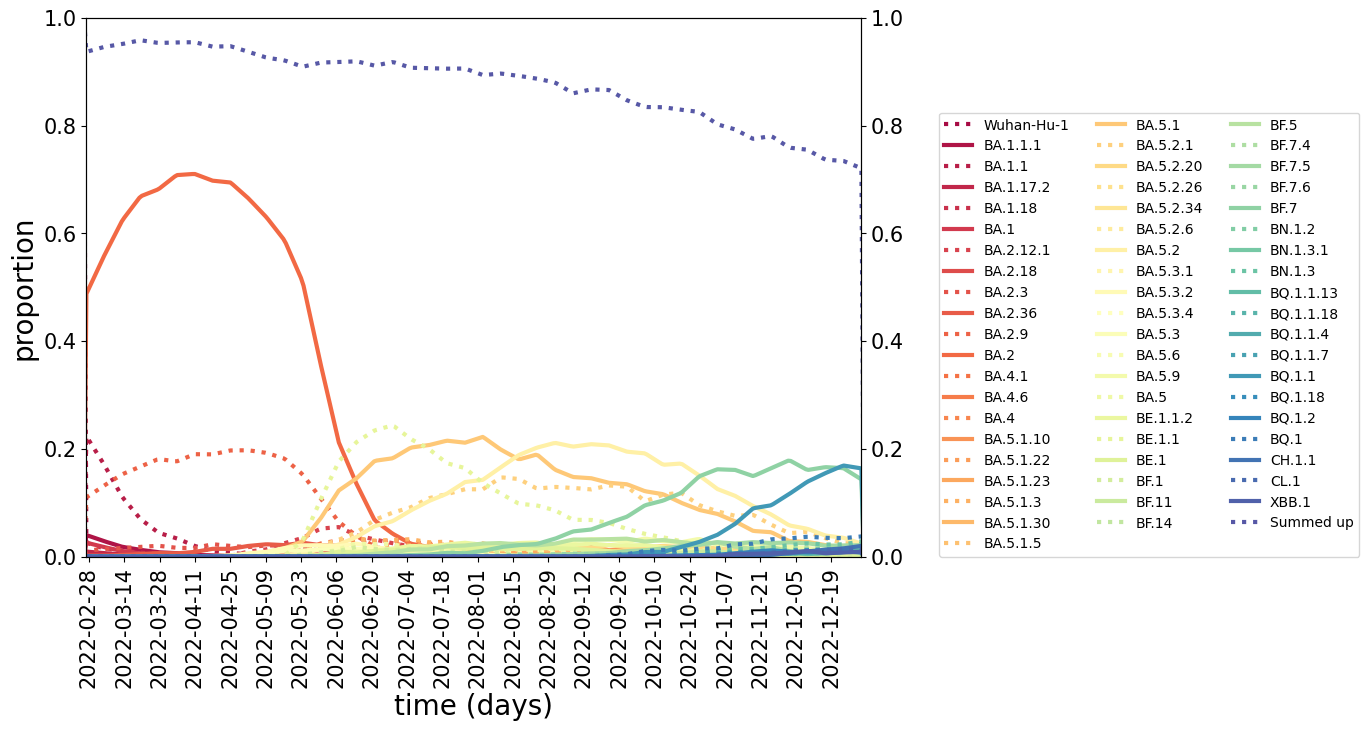

In [19]:
"""Variant considered and their proportion"""
variant_x_list = variant_x_names
variant_proportion = np.zeros((len(t), len(variant_x_list)))
for variant in variant_x_list:
    x = list(variant_x_list).index(variant)
    if variant == "Wuhan-Hu-1":
        variant_proportion[:, x] = proportion_lineage[:, 0]
    else:
        x_lin = list(unique_lineage).index(variant)
        variant_proportion[:, x] = proportion_lineage[:, x_lin+1]
        
"""Plot variant proportions over time without the wild type"""
xysize = (15, 15) # size of xy ticks
labsize = 20 # size of labels and legends
figsize = (10, 7) # figure (width, height)
xval = "time (days)" # name of variable on x axis
yval = "proportion" # name of variable on y axis
labels = variant_x_list

"""Select variants to plot"""
variant_to_plot = variant_x_list #["Wuhan-Hu-1", "BA.5.1.5", "BF.5"]
index_var = np.array([list(variant_x_list).index(var_y) for var_y in variant_to_plot])

Var_prop_data = np.row_stack((variant_proportion.T[index_var, :], np.sum(variant_proportion.T, axis = 0)))
labs_data = list(np.array(labels)[index_var]) + ["Summed up"]

fig, ax = Display(t, Var_prop_data, is_log, labs_data, 
        figsize, xysize, labsize, 
        save_to = "Figures/Variant_Proportions_prev.pdf",
        xval = xval, yval = yval, linewidth = 3,
        palette = "Spectral",
        linestyle = [":", "-"]*int((len(labels)//2)+1))
                  
plt.legend(fontsize = 10, loc = (1.1, 0.))
per_day = 14
plt.xticks(t[::per_day], t_ticks[::per_day], rotation = 90)
plt.legend(fontsize = 10, loc = (1.1, 0.), ncol = 3)
plt.xlim((t[where_first_day], t[where_last_day]))
#ax.hlines(1, xmin = 0, xmax = t[where_last_day], linestyle = "--",linewidth = 2, color = "black", label = mar2022)
ax1 = ax.twinx()
ax.set_ylim((0, 1))
ax1.set_ylim((0,1))
#plt.xlim((t[0], t[where_last_day]))
plt.show()   